In [1]:
import pandas as pd
import numpy as np
import random
import re
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.base import TransformerMixin
from sklearn.preprocessing import scale

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### Data Collection

In [2]:
train_data = pd.read_csv('dataset/offenseval-training-v1.tsv', sep="\t", header=0)
train_data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [3]:
test_data_a = pd.read_csv('dataset/testset-taska.tsv', sep="\t", header=0).astype(str)
test_data_b = pd.read_csv('dataset/testset-taskb.tsv', sep="\t", header=0).astype(str)
test_data_c = pd.read_csv('dataset/test_set_taskc.tsv', sep="\t", header=0).astype(str)

print('test_data_a shape: ', test_data_a.shape)
print('test_data_b shape: ', test_data_b.shape)
print('test_data_c shape: ', test_data_c.shape)

test_data_a shape:  (860, 2)
test_data_b shape:  (240, 2)
test_data_c shape:  (213, 2)


### Data Exploration

In [5]:
#Load dataset
train_data = train_data.values
train_sents_a = np.array(train_data[:,1].astype(str))

# Integer labeling
# NOT : 0, OFF : 1
_, train_label_a = np.unique(train_data[:,2].astype(str), return_inverse=True)
#TIN : 0, UNT : 1, nan: 2
_, train_label_b = np.unique(train_data[:,3].astype(str), return_inverse=True)
#GRP: 0, IND : 1, OTH: 2, nan: 3
_, train_label_c = np.unique(train_data[:,4].astype(str), return_inverse=True)

#TIN : 0, UNT : 1
train_sents_b = np.delete(train_sents_a, np.nonzero(train_label_b == 2), axis=0)
train_label_b = np.delete(train_label_b, np.nonzero(train_label_b == 2), axis=0)

#GRP: 0, IND : 1, OTH: 2
train_sents_c = np.delete(train_sents_a, np.nonzero(train_label_c == 3), axis=0)
train_label_c = np.delete(train_label_c, np.nonzero(train_label_c == 3), axis=0)

rus = RandomOverSampler(random_state=0)
train_sents_b, train_label_b = rus.fit_resample(train_sents_b.reshape(-1, 1), train_label_b)
train_sents_c, train_label_c = rus.fit_resample(train_sents_c.reshape(-1, 1), train_label_c)

train_sents_b = train_sents_b.reshape(-1, )
train_sents_c = train_sents_c.reshape(-1, )

print('train_sents_a shape: ', train_sents_a.shape)
print('train_label_a shape: ', train_label_a.shape)
print('train_sents_b shape: ', train_sents_b.shape)
print('train_label_b shape: ', train_label_b.shape)
print('train_sents_c shape: ', train_sents_c.shape)
print('train_label_c shape: ', train_label_c.shape)

train_sents_a shape:  (13240,)
train_label_a shape:  (13240,)
train_sents_b shape:  (7752,)
train_label_b shape:  (7752,)
train_sents_c shape:  (7221,)
train_label_c shape:  (7221,)


### Word Embedding

In [6]:
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
#!unzip glove.twitter.27B.zip

In [7]:
class MeanEmbeddingTransformer(TransformerMixin):
    def __init__(self):
        self._E = self._load_words()
          
    def _load_words(self):
        E = {}

        with open('glove.twitter.27B.100d.txt', 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
        return E            
    
    def _doc_mean(self, doc):
        return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [8]:
def get_tokenized_corpus(corpus):
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in corpus:
        sentence = re.sub(r'([A-Z])', lambda pat: pat.group(1).lower(), sentence)
        sentence = re.findall(r'\w+', sentence)
        tokenized_corpus.append(sentence)
 
    return tokenized_corpus

In [9]:
met = MeanEmbeddingTransformer()

In [10]:
tokenized_a = get_tokenized_corpus(train_sents_a)
tweets_transformed_a = met.fit_transform(tokenized_a)
tweets_transformed_a = scale(tweets_transformed_a)

In [11]:
tokenized_b = get_tokenized_corpus(train_sents_b)
tweets_transformed_b = met.fit_transform(tokenized_b)
tweets_transformed_b = scale(tweets_transformed_b)

In [12]:
tokenized_c = get_tokenized_corpus(train_sents_c)
tweets_transformed_c = met.fit_transform(tokenized_c)
tweets_transformed_c = scale(tweets_transformed_c)

### Modelling & Validation

In [13]:
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [14]:
# Here we try on using non-deep learning approach and compare several classifiers to find the best one.

def train_and_compare(X, Y):
    # choose algorithms to be compared
    models = []
    models.append(('RF', RandomForestClassifier()))
    models.append(('SVC', SVC()))
    models.append(('LinSVC', LinearSVC()))
    models.append(('MLP', MLPClassifier()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('KN', KNeighborsClassifier()))

    # evaluate the models 
    f1results = []
    accuracyresults = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=10)
        f1score = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='f1_macro')
        accuracy = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
        f1results.append(f1score)
        accuracyresults.append(accuracy)
        names.append(name)
        print('%s: f1= %f (+/-%f), accuracy= %f (+/-%f)' % (name, f1score.mean(), f1score.std(), accuracy.mean(), accuracy.std()))
        
    return f1results, accuracyresults, names

#### Sub-Task A

In [15]:
#data and label
X_a = tweets_transformed_a
Y_a = train_label_a

In [14]:
f1results_a, accuracyresults_a, names_a = train_and_compare(X_a,Y_a)

RF: f1= 0.593030 (+/-0.015977), accuracy= 0.699169 (+/-0.010184)
SVC: f1= 0.702395 (+/-0.015683), accuracy= 0.764350 (+/-0.009836)
LinSVC: f1= 0.673956 (+/-0.012180), accuracy= 0.747810 (+/-0.009412)
MLP: f1= 0.662122 (+/-0.014622), accuracy= 0.703097 (+/-0.012325)
DT: f1= 0.591561 (+/-0.013900), accuracy= 0.631042 (+/-0.013278)
KN: f1= 0.616874 (+/-0.011488), accuracy= 0.671828 (+/-0.012845)


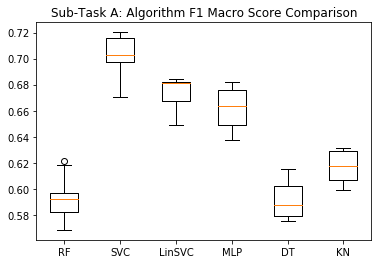

In [27]:
fig = plt.figure()
plt.title('Sub-Task A: Algorithm F1 Macro Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(f1results_a)
ax.set_xticklabels(names_a)
plt.show()

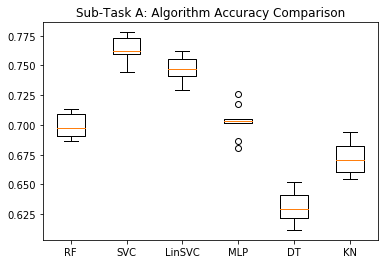

In [28]:
fig = plt.figure()
plt.title('Sub-Task A: Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(accuracyresults_a)
ax.set_xticklabels(names_a)
plt.show()

SVC clearly outperforms the other classification algorithms with f1 score 0.702395 and accuracy 0.764350. Therefore, we will use this algorithm on the test data. 

#### Sub-Task B

In [15]:
#data and label
X_b = tweets_transformed_b
Y_b = train_label_b

In [30]:
f1results_b, accuracyresults_b, names_b = train_and_compare(X_b,Y_b)

RF: f1= 0.925324 (+/-0.144016), accuracy= 0.989295 (+/-0.009119)
SVC: f1= 0.656192 (+/-0.162982), accuracy= 0.864811 (+/-0.010764)
LinSVC: f1= 0.471686 (+/-0.104243), accuracy= 0.602937 (+/-0.051548)
MLP: f1= 0.868015 (+/-0.140447), accuracy= 0.952409 (+/-0.040201)
DT: f1= 0.889720 (+/-0.099698), accuracy= 0.931519 (+/-0.059291)
KN: f1= 0.633952 (+/-0.123394), accuracy= 0.875149 (+/-0.085155)


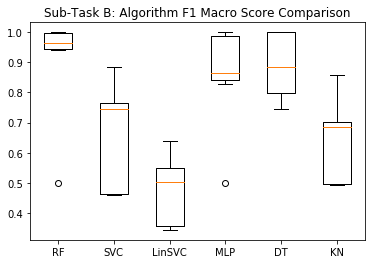

In [31]:
fig = plt.figure()
plt.title('Sub-Task B: Algorithm F1 Macro Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(f1results_b)
ax.set_xticklabels(names_b)
plt.show()

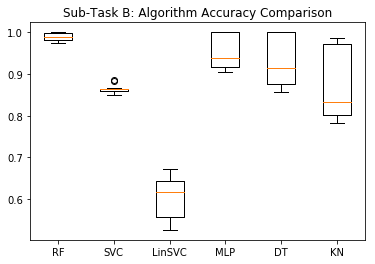

In [32]:
fig = plt.figure()
plt.title('Sub-Task B: Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(accuracyresults_b)
ax.set_xticklabels(names_b)
plt.show()

For Sub-Task B, Random Forest Classifier, Decision Tree Classifier, and MLP Classifier give very good performances. This is especially true for Random Forest Classifier which has the f1 score of 0.925324 and accuracy of 0.989295.

In [48]:
search_params = {
    "n_estimators": range(10,100,10)
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=10), search_params, cv=3, return_train_score=True)
rf_grid.fit(X_b, Y_b)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [49]:
print('The best parameter is ',rf_grid.best_params_)

The best parameter is  {'n_estimators': 90}


#### Sub-Task C

In [28]:
#data and label
X_c = tweets_transformed_c
Y_c = train_label_c

In [33]:
f1results_c, accuracyresults_c, names_c = train_and_compare(X_c,Y_c)

RF: f1= 0.806990 (+/-0.166361), accuracy= 0.897945 (+/-0.087870)
SVC: f1= 0.577676 (+/-0.196170), accuracy= 0.779116 (+/-0.022145)
LinSVC: f1= 0.390351 (+/-0.160490), accuracy= 0.500190 (+/-0.130312)
MLP: f1= 0.878634 (+/-0.100524), accuracy= 0.892409 (+/-0.092876)
DT: f1= 0.797432 (+/-0.152056), accuracy= 0.860835 (+/-0.121742)
KN: f1= 0.486542 (+/-0.121309), accuracy= 0.699367 (+/-0.131324)


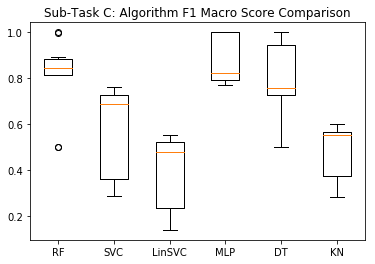

In [34]:
fig = plt.figure()
plt.title('Sub-Task C: Algorithm F1 Macro Score Comparison')
ax = fig.add_subplot(111)
plt.boxplot(f1results_c)
ax.set_xticklabels(names_c)
plt.show()

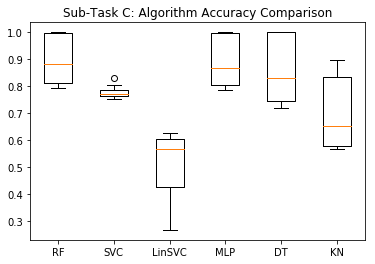

In [35]:
fig = plt.figure()
plt.title('Sub-Task C: Algorithm Accuracy Comparison')
ax = fig.add_subplot(111)
plt.boxplot(accuracyresults_c)
ax.set_xticklabels(names_c)
plt.show()

Although Random Forest Classifier, MLP Classifier and Decision Tree Classifier have high accuracy, but looking at the f1 score, MLP Classifier outperforms the other algorithm with f1 score 0.878634 and accuracy 0.892409.

In [52]:
search_params = {
    "solver": np.array(['sgd','adam']),
    "activation": np.array(['relu','tanh']),
    "learning_rate_init": [0.0001,0.0005,0.001]
}
rf_grid = GridSearchCV(MLPClassifier(random_state=10), search_params, cv=3, return_train_score=True)
rf_grid.fit(X_c, Y_c)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=10, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'solver': array(['sgd', 'adam'], dtype='<U4'), 'activation': array(['relu', 'tanh'], dtype='<U4'), 'learning_rate_init': [0.0001, 0.0005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [53]:
print('The best parameter is ',rf_grid.best_params_)

The best parameter is  {'activation': 'tanh', 'learning_rate_init': 0.001, 'solver': 'adam'}


### Predicting

#### Sub-Task A

In [48]:
tokenized_test_a = get_tokenized_corpus(test_data_a['tweet'])
tweets_transformed_test_a = met.fit_transform(tokenized_test_a)
tweets_transformed_test_a = scale(tweets_transformed_test_a)

In [50]:
svc = SVC()
svc.fit(X_a, Y_a)
y_pred_a = svc.predict(tweets_transformed_test_a)

In [51]:
test_data_a['label'] = y_pred_a
test_data_a['label'][test_data_a['label']==0] = 'NOT'
test_data_a['label'][test_data_a['label']==1] = 'OFF'

In [61]:
test_data_a.drop(columns=['tweet']).to_csv('submission_a.csv', header=False, index=False)

#### Sub-Task B

In [16]:
tokenized_test_b = get_tokenized_corpus(test_data_b['tweet'])
tweets_transformed_test_b = met.fit_transform(tokenized_test_b)
tweets_transformed_test_b = scale(tweets_transformed_test_b)

In [30]:
rf = RandomForestClassifier(n_estimators=90)
rf.fit(X_b, Y_b)
y_pred_b = rf.predict(tweets_transformed_test_b)

In [18]:
test_data_b['label'] = y_pred_b
test_data_b['label'][test_data_b['label']==0] = 'TIN'
test_data_b['label'][test_data_b['label']==1] = 'UNT'

In [19]:
test_data_b.drop(columns=['tweet']).to_csv('submission_b.csv', header=False, index=False)

#### Sub-Task C

In [37]:
tokenized_test_c = get_tokenized_corpus(test_data_c['tweet'])
tweets_transformed_test_c = met.fit_transform(tokenized_test_c)
tweets_transformed_test_c = scale(tweets_transformed_test_c)

In [38]:
mlp = MLPClassifier(activation = 'tanh', learning_rate_init = 0.001, solver = 'adam')
mlp.fit(X_c, Y_c)
y_pred_c = mlp.predict(tweets_transformed_test_c)

In [39]:
test_data_c['label'] = y_pred_c
test_data_c['label'][test_data_c['label']==0] = 'GRP'
test_data_c['label'][test_data_c['label']==1] = 'IND'
test_data_c['label'][test_data_c['label']==2] = 'OTH'

In [40]:
test_data_c.drop(columns=['tweet']).to_csv('submission_c.csv', header=False, index=False)